In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
df = pd.read_csv('Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers

    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])

    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])

    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c)  # in kilometers

    return d

In [7]:
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [9]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = df['Hour'].map(lambda x: 'am' if x < 12 else 'pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [10]:
con_cols = ['dist_km', 'passenger_count']
cat_cols = ['Hour', 'AMorPM', 'Weekday', ]
y_col = ['fare_amount']

In [11]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [12]:
hour = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
weekday = df['Weekday'].cat.codes.values
cats = np.stack([hour, ampm, weekday], axis=1)
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [14]:
cats = torch.LongTensor(cats)
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [20]:
conts = np.stack([df[col].values for col in con_cols], axis=1)
conts = torch.FloatTensor(conts)
conts

tensor([[2.1263, 1.0000],
        [1.3923, 1.0000],
        [3.3268, 2.0000],
        ...,
        [5.0525, 3.0000],
        [1.2089, 1.0000],
        [1.4274, 3.0000]])

In [21]:
y = torch.FloatTensor(df[y_col].values)
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [22]:
print(cats.shape)
print(conts.shape)
print(y.shape)

torch.Size([120000, 3])
torch.Size([120000, 2])
torch.Size([120000, 1])


In [23]:
cat_size = [len(df[col].cat.categories) for col in cat_cols]
cat_size

[24, 2, 7]

In [24]:
emb_size = [(size, min(50, (size + 1) // 2)) for size in cat_size]
emb_size

[(24, 12), (2, 1), (7, 4)]

In [47]:
class TabularModel(nn.Module):
    def __init__(self, emb_size, con_size, out_size, layers_conf, p):
        super().__init__()
        self.embedding_layer = nn.ModuleList([nn.Embedding(insize, outsize) for insize, outsize in emb_size])
        self.norm_layer = nn.BatchNorm1d(con_size)
        self.dropout_layer = nn.Dropout(p)
        total_size = con_size + sum([size for a, size in emb_size])
        layerlist = []
        for i, layer in enumerate(layers_conf):
            layerlist.append(nn.Linear(total_size,layer))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(layer))
            layerlist.append(nn.Dropout(p))
            total_size=layer
        layerlist.append(nn.Linear(layers_conf[-1],out_size))
        self.layers=nn.Sequential(*layerlist)
    def forward(self,data_con,data_cat):
        embedding=[]
        for i,fun in enumerate(self.embedding_layer):
            embedding.append(fun(data_cat[:,i]))
        embedding=torch.cat(embedding,1)
        embedding=self.dropout_layer(embedding)
        data_con=self.norm_layer(data_con)
        total_input=torch.cat([embedding,data_con],1)
        output=self.layers(total_input)
        return output

In [48]:
model=TabularModel(emb_size,conts.shape[1],1,[200,150,100],0.4)

In [49]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.00126)

In [50]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [51]:
import time
start=time.time()
epochs=500
losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(con_train,cat_train)
    loss=torch.sqrt(criterion(y_pred,y_train))
    losses.append(loss)
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.61871815
epoch:  26  loss: 11.89983749
epoch:  51  loss: 10.48421288
epoch:  76  loss: 9.21840096
epoch: 101  loss: 7.90461922
epoch: 126  loss: 6.32872438
epoch: 151  loss: 4.77501297
epoch: 176  loss: 3.85446239
epoch: 201  loss: 3.71314502
epoch: 226  loss: 3.67134619
epoch: 251  loss: 3.63246107
epoch: 276  loss: 3.61237359
epoch: 301  loss: 3.57763219
epoch: 326  loss: 3.55411029
epoch: 351  loss: 3.53635454
epoch: 376  loss: 3.55016041
epoch: 401  loss: 3.52342176
epoch: 426  loss: 3.54507732
epoch: 451  loss: 3.50096965
epoch: 476  loss: 3.49578595
epoch: 500  loss: 3.49943876

Duration: 692 seconds


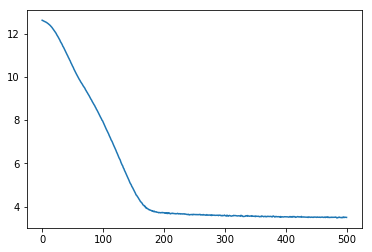

In [52]:
plt.plot(range(epochs),losses)

In [54]:
with torch.no_grad():
    y_val = model(con_test,cat_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.41667509


In [55]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')